# Code Lab 4A: CNN for Text Classification

In this Code Lab, we are going to implement *Convolutional Neural Networks for Sentence Classification* (Yoon Kim, 2014).

In his [paper](https://arxiv.org/abs/1408.5882), Yoon Kim proposed several techniques to achieve good text classification accuracy with minimal hyper-parameter tuning.

This notebook consist of 4 main sections:

1. Preparing the data
2. Implementing Yoon Kim's CNN model
3. Training the model
4. Evaluating the model

In [1]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)

In [2]:
import numpy as np
import re, sys, csv, pickle
from tqdm import tqdm_notebook

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


### 1. Prepare the data
**Read from dataset**

In [3]:
# download pre-trained GloVe vectors

import keras

GLOVE_URL = "https://s3-ap-southeast-1.amazonaws.com/deeplearning-iap-material/glove.6B.100d.txt.zip"
GLOVE_DIR = keras.utils.get_file("glove.6B.100d.txt.zip", GLOVE_URL, cache_subdir='datasets', extract=True)
print("GloVe data present at", GLOVE_DIR)
GLOVE_DIR = GLOVE_DIR.replace(".zip", "")

134414336/134409644 [==============================] - 3s 0us/step
GloVe data present at /home/jovyan/.keras/datasets/glove.6B.100d.txt.zip


In [4]:
from nltk.corpus import stopwords
def clean_text(text, remove_stopwords=False):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [5]:
texts, labels = [], [] # empty lists for the sentences and labels

data_neg = open("datasets/stanford_movie_neg.txt", "rb") 
for line in tqdm_notebook(data_neg, total=5331): 
    texts.append(clean_text(line, remove_stopwords=False))
    labels.append(int(0))

In [6]:
data_pos = open("datasets/stanford_movie_pos.txt", "rb") 
for line in tqdm_notebook(data_pos, total=5331): 
    texts.append(clean_text(line, remove_stopwords=False))
    labels.append(int(1))

In [7]:
print("Sample negative:", texts[0], labels[0])
print("Sample positive:", texts[-1], labels[-1])

Sample negative: simplistic silly and tedious 0
Sample positive: provides a porthole into that noble trembling incoherence that defines us all 1


**Word Tokenizer**

In [8]:
CACHE_TOKENIZER = True

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

if CACHE_TOKENIZER:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("[i] Saved word tokenizer to file: tokenizer.pickle")

# to use cached tokenizer:
"""
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
"""

[i] Saved word tokenizer to file: tokenizer.pickle


"\nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n"

**Generate the array of sequences from dataset**

In [9]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Vocabulary size:', len(word_index))

# pad on both ends
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Vocabulary size: 20659


**Create the train-validation split**

In [10]:
labels = to_categorical(np.asarray(labels)) # convert the category label to one-hot encoding
print('[i] Shape of data tensor:', data.shape)
print('[i] Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:",y_train.sum(axis=0))
print("[+] Validation:",y_val.sum(axis=0))

[i] Shape of data tensor: (10662, 30)
[i] Shape of label tensor: (10662, 2)
[i] Number of entries in each category:
[+] Training: [4270. 4260.]
[+] Validation: [1061. 1071.]


**What does the data look like?**

In [11]:
print("Tokenized sequence:\n", data[0])
print("")
print("One-hot label:\n", labels[0])

Tokenized sequence:
 [   5  112  117 2633 3266  818 1769    3   26 2633 3266  818  453 5669
    5 6090    7   14 2010  107  454 1536  228   30   79    0    0    0
    0    0]

One-hot label:
 [1. 0.]


### 2. Create the model
Yoon Kim's model has several notable features:
![model-structure](notebook_imgs/yoon_kim_structure.png)
* two sets of word embeddings for what he terms a **"multi-channel" approach**.
  * One of the word embeddings will be frozen (**"static channel"**), and one will be modified during the training process (**"non-static channel"**). 
* multiple convolutional kernel sizes

We will now start to create the model in `Keras`.

**Load word embeddings into an `embeddings_index`**

Create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.

We use a set from [pre-trained GloVe vectors from Stanford](https://nlp.stanford.edu/projects/glove/).

In [12]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] (long) Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(" Completed!")

[i] (long) Loading GloVe from: /home/jovyan/.keras/datasets/glove.6B.100d.txt ...Done.
[+] Proceeding with Embedding Matrix... Completed!


In [13]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector

**Create the `Embedding` layers**

In [14]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # input to the model

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

l_embed = Concatenate(axis=1)([embedded_sequences_frozen, embedded_sequences_train])

**Create the CNN layer with multiple kernel (filter) sizes**

In [15]:
l_conv_3 = Conv1D(filters=128,kernel_size=3,activation='relu')(l_embed)
l_conv_4 = Conv1D(filters=128,kernel_size=4,activation='relu')(l_embed)
l_conv_5 = Conv1D(filters=128,kernel_size=5,activation='relu')(l_embed)

l_conv = Concatenate(axis=1)([l_conv_3, l_conv_4, l_conv_5])

Followed by the rest of the model (boring!!)

In [16]:
l_pool = MaxPooling1D(4)(l_conv)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense) #follows the number of classes

**Compile the model into a static graph for training**

In [17]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      2066000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 100)      2066000     input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 60, 100)      0           embedding_1[0][0]                
                                                                 embedding_2[0][0]                
__________

**Visualisation**

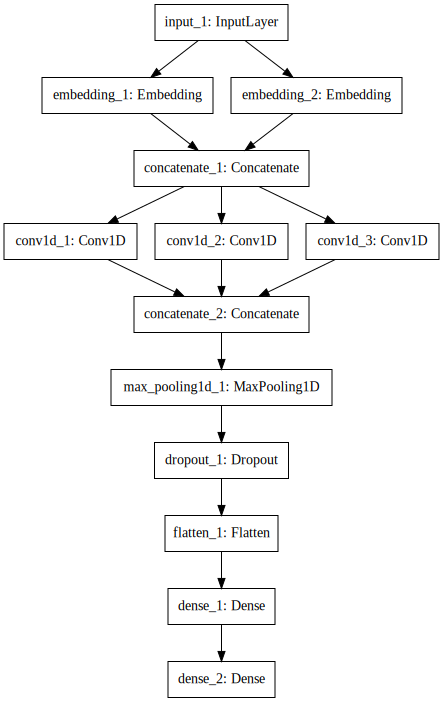

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 3. Train the model

In [19]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                      epochs=30, batch_size=64)

Training Progress:
Train on 8530 samples, validate on 2132 samples
Epoch 1/30
8530/8530 [==============================] - 3s 390us/step - loss: 0.7070 - acc: 0.5885 - val_loss: 0.6193 - val_acc: 0.6543
Epoch 2/30
8530/8530 [==============================] - 2s 186us/step - loss: 0.5520 - acc: 0.7165 - val_loss: 0.5816 - val_acc: 0.6886
Epoch 3/30
8530/8530 [==============================] - 2s 185us/step - loss: 0.4706 - acc: 0.7743 - val_loss: 0.5411 - val_acc: 0.7270
Epoch 4/30
8530/8530 [==============================] - 2s 185us/step - loss: 0.3883 - acc: 0.8274 - val_loss: 0.6091 - val_acc: 0.7111
Epoch 5/30
8530/8530 [==============================] - 2s 187us/step - loss: 0.2973 - acc: 0.8736 - val_loss: 0.5863 - val_acc: 0.7645
Epoch 6/30
8530/8530 [==============================] - 2s 188us/step - loss: 0.2150 - acc: 0.9124 - val_loss: 0.5840 - val_acc: 0.7575
Epoch 7/30
8530/8530 [==============================] - 2s 186us/step - loss: 0.1524 - acc: 0.9397 - val_loss: 0.6612

In [20]:
# save the model
#model.save("best_weights.h5")

### 4. Evaluate the model

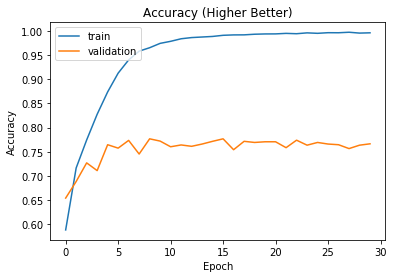

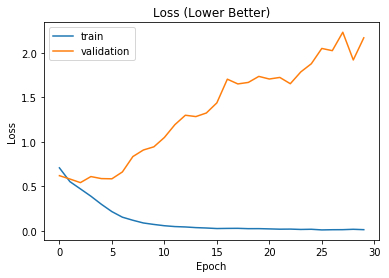

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle

classes = ["positive", "negative"]

In [23]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    positive       0.79      0.72      0.76      1061
    negative       0.75      0.81      0.78      1071

   micro avg       0.77      0.77      0.77      2132
   macro avg       0.77      0.77      0.77      2132
weighted avg       0.77      0.77      0.77      2132



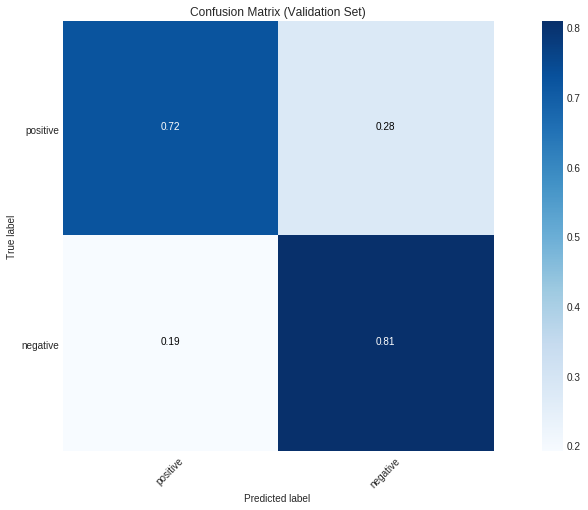

In [24]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)

In [25]:
model.save("cnn.h5")